In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import decimal
import cv2

decimal.getcontext().prec = 100


def spherical_to_cartesian(spherical: np.array) -> np.array:
    x = spherical[:, 0] * np.sin(spherical[:, 1]) * np.cos(spherical[:, 2])
    y = spherical[:, 0] * np.sin(spherical[:, 1]) * np.sin(spherical[:, 2])
    z = spherical[:, 0] * np.cos(spherical[:, 1])
    return np.array([x, y, z])


def fit_plane(points):
    """
    Fits a plane to a set of 3D points using the least-squares method.

    Args:
        points (np.ndarray): An Nx3 matrix where each row is a point (x, y, z).

    Returns:
        (np.ndarray, float): Normal vector of the plane and distance from the origin.
    """
    points = np.asarray(points)
    assert points.shape[1] == 3, "Input points must be a Nx3 matrix."

    centroid = np.mean(points, axis=0)

    centered_points = points - centroid

    _, _, vh = np.linalg.svd(centered_points)

    normal_vector = vh[-1]

    d = -np.dot(normal_vector, centroid)

    return normal_vector, d


def generate_plane(normal, d, centroid, size=10, step=1):
    """
    Generates a grid of points to visualize the fitted plane.
    """
    # Create a grid of points around the centroid
    x_range = np.arange(centroid[0] - size, centroid[0] + size, step)
    y_range = np.arange(centroid[1] - size, centroid[1] + size, step)
    x, y = np.meshgrid(x_range, y_range)

    # Plane equation: ax + by + cz + d = 0 -> z = (-d - ax - by) / c
    a, b, c = normal
    z = (-d - a * x - b * y) / c

    return np.stack((x, y, z), axis=-1)


def visualize(points, plane_x, plane_y, plane_z):
    """
    Visualizes 3D points and a fitted plane using Matplotlib.
    """
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection="3d")

    ax.scatter(
        points[:, 0], points[:, 1], points[:, 2], color="r", label="Electron Points"
    )

    ax.plot_surface(
        plane_x, plane_y, plane_z, alpha=0.5, color="blue", label="Fitted Plane"
    )

    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.set_title("Plane Fitting Visualization")
    ax.legend()
    plt.show()

def point_to_plane_distance(point, normal, d):
    """
    Calculates the perpendicular distance from a point to a plane.

    Parameters:
        point (array-like): The coordinates of the point [x, y, z].
        normal (array-like): The normal vector of the plane [a, b, c].
        d (float): The distance from the origin to the plane.

    Returns:
        float: The perpendicular distance from the point to the plane.
    """
    point = np.asarray(point)
    normal = np.asarray(normal)

    numerator = np.abs(np.dot(normal, point) + d)

    denominator = np.linalg.norm(normal)

    return numerator / denominator


def project_onto_plane(points, normal, point_on_plane):
    """
    Projects 3D points onto a plane defined by a normal vector and a point on the plane.

    Args:
        points (ndarray): Array of 3D points (N x 3).
        normal (ndarray): Normal vector of the plane (1 x 3).
        point_on_plane (ndarray): A point on the plane (1 x 3).

    Returns:
        ndarray: Projected 3D points (N x 3).
    """
    normal = normal / np.linalg.norm(normal)
    projections = []
    for p in points:
        vector = p - point_on_plane
        distance = np.dot(vector, normal)
        projection = p - distance * normal
        projections.append(projection)
    return np.array(projections)


def rotate_to_z_plane(points, plane_normal):
    """
    Rotates 3D points to align with the z=0 plane.

    Args:
        points (ndarray): Array of 3D points (N x 3).
        plane_normal (ndarray): Normal vector of the plane (1 x 3).

    Returns:
        ndarray: Rotated 3D points (N x 3).
    """
    plane_normal = plane_normal / np.linalg.norm(plane_normal)
    target_normal = np.array([0, 0, 1])

    rotation_axis = np.cross(plane_normal, target_normal)
    rotation_angle = np.arccos(np.dot(plane_normal, target_normal))

    rotation_axis = rotation_axis / np.linalg.norm(rotation_axis)

    # Create the rotation matrix using Rodrigues' rotation formula
    K = np.array(
        [
            [0, -rotation_axis[2], rotation_axis[1]],
            [rotation_axis[2], 0, -rotation_axis[0]],
            [-rotation_axis[1], rotation_axis[0], 0],
        ]
    )
    I = np.eye(3)
    R = I + np.sin(rotation_angle) * K + (1 - np.cos(rotation_angle)) * np.dot(K, K)

    rotated_points = np.dot(points, R.T)
    return rotated_points


def cartesian_to_polar(cartesian: np.array) -> np.array:
    r = np.linalg.norm(cartesian, axis=1)
    theta = np.arctan2(cartesian[:, 1], cartesian[:, 0])
    return np.array([r, theta]).T


def spherical_to_polar(spherical: np.array) -> np.array:
    points = spherical_to_cartesian(spherical).T
    print(points.shape)

    _, _, vh = np.linalg.svd(points[:2000])
    normal = vh[-1]
    point_on_plane = np.mean([points[0], points[-1]], axis=0)
    projected_points = project_onto_plane(points, normal, point_on_plane)
    rotated_points = rotate_to_z_plane(projected_points, normal)
    polar = cartesian_to_polar(rotated_points)

    return polar


def compute_cos_psi(phi, theta, sin_0, cos_0):
    return sin_0 * np.sin(theta) * np.cos(phi) + cos_0 * np.cos(theta)


def compute_psi_dot(theta_dot, theta, phi_dot):
    return np.sqrt(
        theta_dot * theta_dot + np.sin(theta) * np.sin(theta) * phi_dot * phi_dot
    )

def compute_sin_theta_0(k, m):
    return m / k

def compute_cos_theta_0(k, m):
    return np.sqrt(k * k - m * m) / k

In [6]:
sphere_3_2_1_d31 = pd.read_csv('results/sphere_3_2_1_d31.csv')

In [7]:
sin_0 = compute_sin_theta_0(2, 1)
cos_0 = compute_cos_theta_0(2, 1)
cos_psi_3_2_1_d31 = compute_cos_psi(sphere_3_2_1_d31['phi'], sphere_3_2_1_d31['theta'], sin_0, cos_0)

In [8]:
polar_3_2_d19 = pd.read_csv('results/polar_3_2_d19.csv')

Text(0.5, 1.0, 'Comparison of $\\cos(\\psi)$ between 3D and 2D in non-relativistic case')

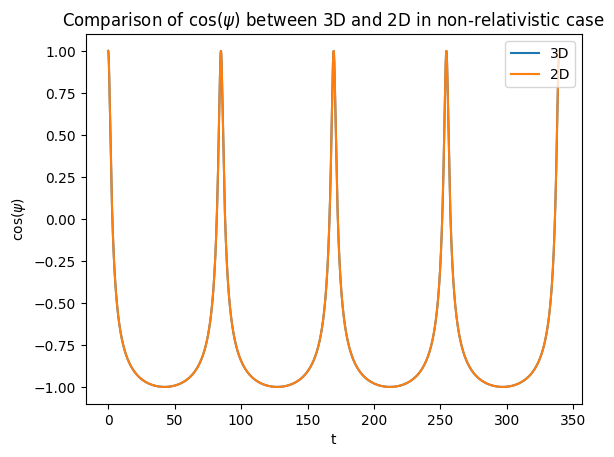

In [13]:
plt.plot(sphere_3_2_1_d31['t'], cos_psi_3_2_1_d31)
plt.plot(polar_3_2_d19['t'], np.cos(polar_3_2_d19['phi']))
plt.xlabel('t')
plt.ylabel('$\\cos(\\psi)$')
plt.legend(['3D', '2D'])
plt.title('Comparison of $\\cos(\\psi)$ between 3D and 2D in non-relativistic case')

In [10]:
df_cos_psi_3_2_1_d31 = cos_psi_3_2_1_d31 - np.cos(polar_3_2_d19['phi'])

Text(0.5, 1.0, 'Difference between $cos(\\psi)$ in 3D and 2D in non-relativistic case')

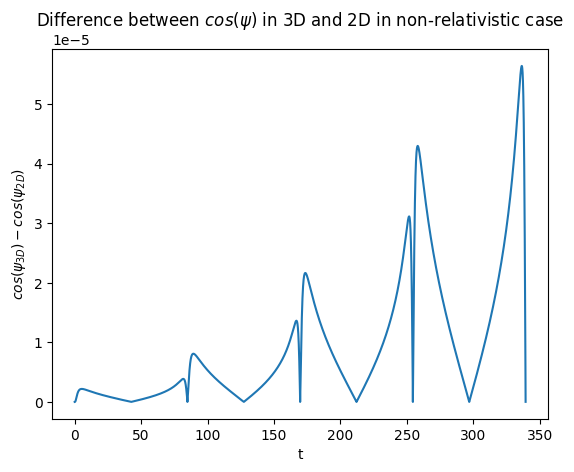

In [14]:
plt.plot(sphere_3_2_1_d31['t'], np.abs(df_cos_psi_3_2_1_d31))
plt.xlabel('t')
plt.ylabel('$cos(\\psi_{3D}) - cos(\\psi_{2D})$')
plt.title('Difference between $cos(\\psi)$ in 3D and 2D in non-relativistic case')

In [16]:
psi_dot_3_2_1_d31 = compute_psi_dot(sphere_3_2_1_d31['theta_dot'], sphere_3_2_1_d31['theta'], sphere_3_2_1_d31['phi_dot'])

In [17]:
df_psi_dot_3_2_1_d31 = psi_dot_3_2_1_d31 - polar_3_2_d19['phi_dot']

Text(0.5, 1.0, 'Difference between $\\dot{\\psi}$ in 3D and 2D in non-relativistic case')

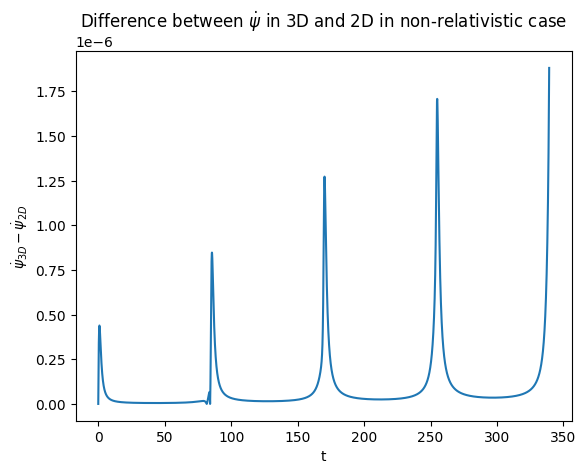

In [18]:
plt.plot(sphere_3_2_1_d31['t'], np.abs(df_psi_dot_3_2_1_d31))
plt.xlabel('t')
plt.ylabel('$\\dot{\\psi}_{3D} - \\dot{\\psi}_{2D}$')
plt.title('Difference between $\\dot{\\psi}$ in 3D and 2D in non-relativistic case')

In [5]:
s3d_1_1_0 = pd.read_csv('d33/3d_1_1_0.csv')

/tmp/ipykernel_47205/1290530495.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  s3d_1_1_0 = pd.read_csv('d33/3d_1_1_0.csv')


In [6]:
s3d_1_1_0

,t,r,r_dot,r_dot_dot,phi,phi_dot,phi_dot_dot,theta,theta_dot,theta_dot_dot
0,0.000001,1.0,0.0,0.0,1.570796,0.0,0.0,0.000001,1.0,0.0
1,0.000501,1.0,0.0,0.0,1.570796,0.0,0.0,0.001001,1.0,0.0
2,0.001001,1.0,0.0,0.0,1.570796,0.0,0.0,0.002001,1.0,0.0
3,0.001501,1.0,0.0,0.0,1.570796,0.0,0.0,0.003001,1.0,0.0
4,0.002001,1.0,0.0,0.0,1.570796,0.0,0.0,0.004001,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...
1104108,552.054001,1.0,0.0,0.00000000000000000000E+00,-1.570796,0.0,0.0,1.734139,-1.0,0.0
1104109,552.054501,1.0,0.0,0.00000000000000000000E+00,-1.570796,0.0,0.0,1.733139,-1.0,0.0
1104110,552.055001,1.0,0.0,0.00000000000000000000E+00,-1.570796,0.0,0.0,1.732139,-1.0,0.0
1104111,552.055501,1.0,0.0,0.00000000000000000000E+00,-1.570796,0.0,0.0,1.731139,-1.0,0.0


In [7]:
s3d_1_1_0 = s3d_1_1_0.dropna()

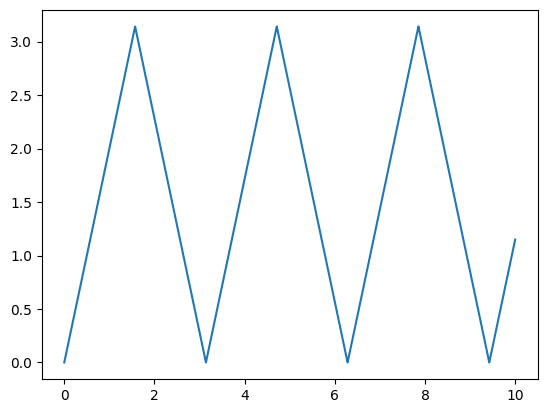

In [19]:
j = 10
start = 0
end = start + j

plt.plot(s3d_1_1_0['t'][s3d_1_1_0['t'] < end], s3d_1_1_0['theta'][s3d_1_1_0['t'] < end])

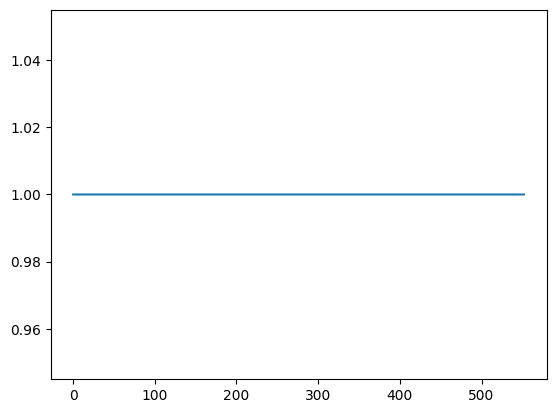

In [9]:
plt.plot(s3d_1_1_0['t'], s3d_1_1_0['r'])

In [9]:
s3d_2_1_0 = pd.read_csv('d33/3d_2_1_0.csv')
s2d_2_1_0 = pd.read_csv('d33/2d_2_1_0.csv')

In [29]:
sin_0 = compute_sin_theta_0(1, 0)
cos_0 = compute_cos_theta_0(1, 0)
cos_psi_3d_2_1_0 = compute_cos_psi(s3d_2_1_0['phi'], s3d_2_1_0['theta'], sin_0, cos_0)

Text(0.5, 1.0, 'Comparison of $\\cos(\\psi)$ between 3D and 2D in non-relativistic case')

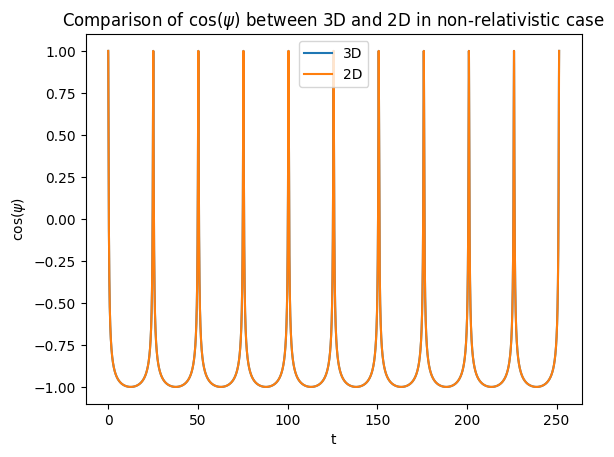

In [31]:
plt.plot(s3d_2_1_0['t'], cos_psi_3d_2_1_0)
plt.plot(s2d_2_1_0['t'], np.cos(s2d_2_1_0['phi']))
plt.xlabel('t')
plt.ylabel('$\\cos(\\psi)$')
plt.legend(['3D', '2D'])
plt.title('Comparison of $\\cos(\\psi)$ between 3D and 2D in non-relativistic case')

In [13]:
s3d_2_1_1 = pd.read_csv('d33/3d_2_1_1_d1.csv')

In [14]:
s3d_2_1_1 

,t,r,r_dot,r_dot_dot,phi,phi_dot,phi_dot_dot,theta,theta_dot,theta_dot_dot
0,0.000001,0.535898,0.000000,3.015544,1.570796,0.0,0.0,1.570800,3.482051,0.0
1,0.000501,0.535900,0.003016,3.015509,1.570796,0.0,0.0,1.574282,3.482031,0.0
2,0.001001,0.535904,0.006031,3.015404,1.570796,0.0,0.0,1.577764,3.481973,0.0
3,0.001501,0.535912,0.009046,3.015228,1.570796,0.0,0.0,1.581246,3.481875,0.0
4,0.002001,0.535923,0.012061,3.014981,1.570796,0.0,0.0,1.584728,3.481738,0.0
...,...,...,...,...,...,...,...,...,...,...
201093,100.546501,0.535919,-0.013475,3.015068,1.570796,0.0,0.0,1.555224,3.481786,0.0
201094,100.547001,0.535907,-0.010460,3.015348,1.570796,0.0,0.0,1.558706,3.481942,0.0
201095,100.547501,0.535898,-0.007444,3.015558,1.570796,0.0,0.0,1.562188,3.482058,0.0
201096,100.548001,0.535892,-0.004429,3.015697,1.570796,0.0,0.0,1.565670,3.482135,0.0


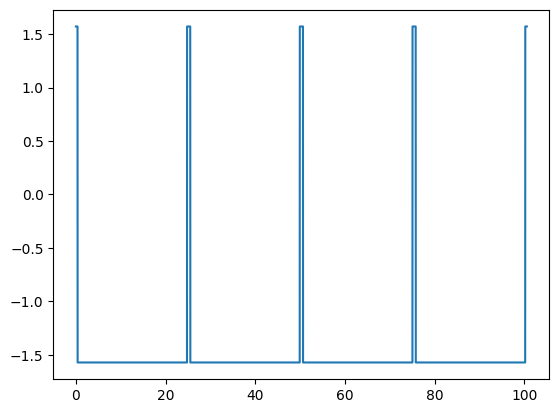

In [15]:
plt.plot(s3d_2_1_1['t'], s3d_2_1_1['phi'])

In [41]:
s3d_2_1_1['phi'].describe()

count    502878.000000
mean         -1.480249
std           0.525609
min          -1.570796
25%          -1.570796
50%          -1.570796
75%          -1.570796
max           1.570796
Name: phi, dtype: float64

In [16]:
sin_0 = compute_sin_theta_0(1, 1)
cos_0 = compute_cos_theta_0(1, 1)

cos_psi_3d_2_1_1 = compute_cos_psi(s3d_2_1_1['phi'], s3d_2_1_1['theta'], sin_0, cos_0)

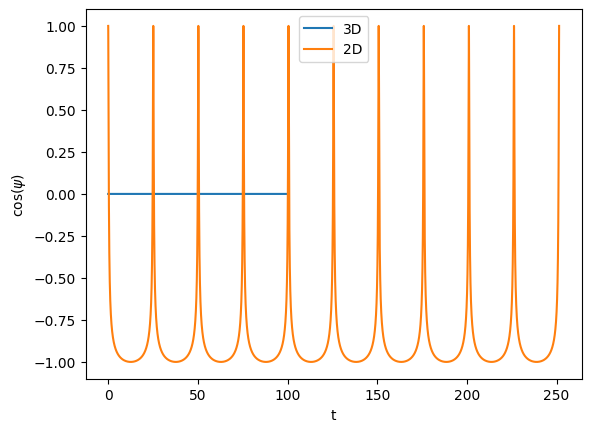

In [17]:
plt.plot(s3d_2_1_1['t'], cos_psi_3d_2_1_1)
plt.plot(s2d_2_1_0['t'], np.cos(s2d_2_1_0['phi']))
plt.xlabel('t')
plt.ylabel('$\\cos(\\psi)$')
plt.legend(['3D', '2D'])

In [42]:
s3d_3_1_0 = pd.read_csv('d33/3d_3_1_0.csv')
s2d_3_1_0 = pd.read_csv('d33/2d_3_1_0.csv')

In [43]:
sin_0 = compute_sin_theta_0(1, 0)
cos_0 = compute_cos_theta_0(1, 0)

cos_psi_3d_3_1_0 = compute_cos_psi(s3d_3_1_0['phi'], s3d_3_1_0['theta'], sin_0, cos_0)

Text(0.5, 1.0, 'Comparison of $\\cos(\\psi)$ between 3D and 2D in non-relativistic case')

/home/musa/files/atom bohr sim/.venv/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/musa/files/atom bohr sim/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


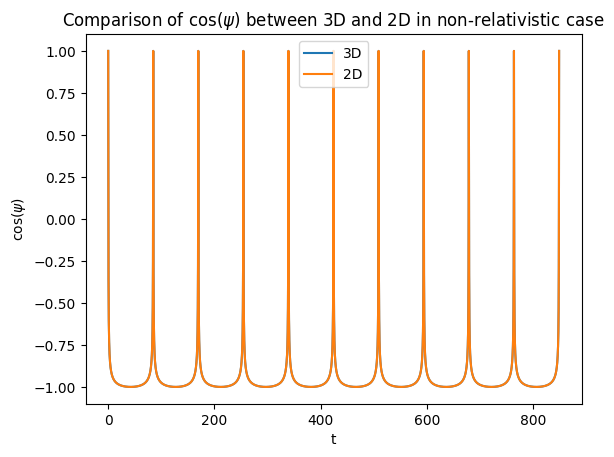

In [44]:
plt.plot(s3d_3_1_0['t'], cos_psi_3d_3_1_0)
plt.plot(s2d_3_1_0['t'], np.cos(s2d_3_1_0['phi']))
plt.xlabel('t')
plt.ylabel('$\\cos(\\psi)$')
plt.legend(['3D', '2D'])
plt.title('Comparison of $\\cos(\\psi)$ between 3D and 2D in non-relativistic case')

In [45]:
s3d_3_1_1 = pd.read_csv('d33/3d_3_1_1.csv')

In [48]:
sin_0 = compute_sin_theta_0(1, 1)
cos_0 = compute_cos_theta_0(1, 1)
cos_psi_3d_3_1_1 = compute_cos_psi(s3d_3_1_1['phi'], s3d_3_1_1['theta'], sin_0, cos_0)

Text(0.5, 1.0, 'Comparison of $\\cos(\\psi)$ between 3D and 2D in non-relativistic case')

/home/musa/files/atom bohr sim/.venv/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/musa/files/atom bohr sim/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


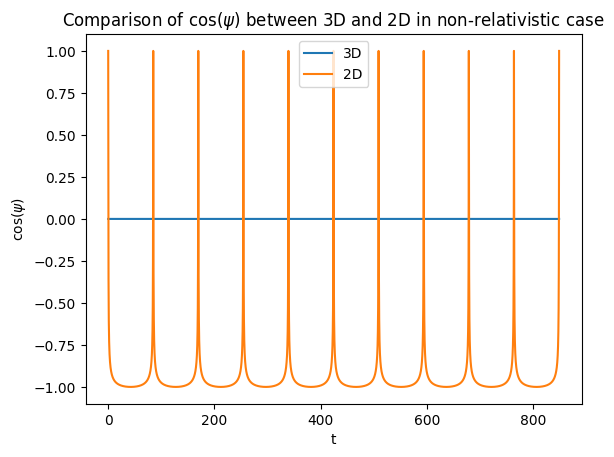

In [49]:
plt.plot(s3d_3_1_1['t'], cos_psi_3d_3_1_1)
plt.plot(s2d_3_1_0['t'], np.cos(s2d_3_1_0['phi']))
plt.xlabel('t')
plt.ylabel('$\\cos(\\psi)$')
plt.legend(['3D', '2D'])
plt.title('Comparison of $\\cos(\\psi)$ between 3D and 2D in non-relativistic case')

In [37]:
s3d_3_2_0 = pd.read_csv('d33/3d_3_2_0.csv')
s2d_3_2_0 = pd.read_csv('d33/2d_3_2_0.csv')

In [51]:
sin_0 = compute_sin_theta_0(2, 0)
cos_0 = compute_cos_theta_0(2, 0)
cos_psi_3d_3_2_0 = compute_cos_psi(s3d_3_2_0['phi'], s3d_3_2_0['theta'], sin_0, cos_0)

Text(0.5, 1.0, 'Comparison of $\\cos(\\psi)$ between $(n=3, k=2, m=0)$ in 3D and 2D in non-relativistic case')

/home/musa/files/atom bohr sim/.venv/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/musa/files/atom bohr sim/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


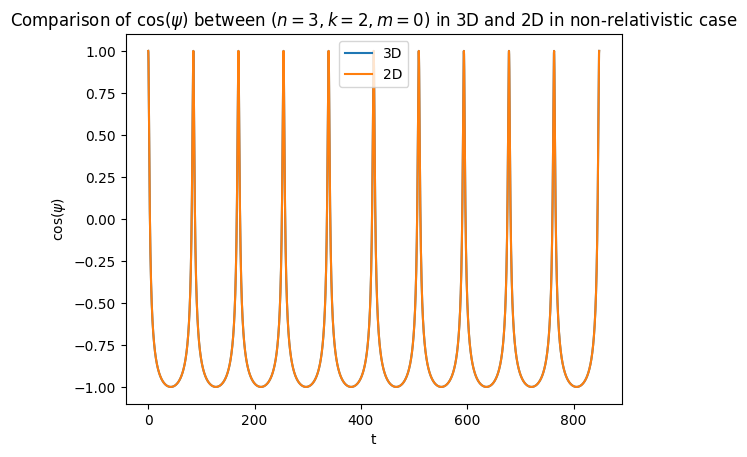

In [54]:
plt.plot(s3d_3_2_0['t'], cos_psi_3d_3_2_0)
plt.plot(s2d_3_2_0['t'], np.cos(s2d_3_2_0['phi']))
plt.xlabel('t')
plt.ylabel('$\\cos(\\psi)$')
plt.legend(['3D', '2D'])
plt.title('Comparison of $\\cos(\\psi)$ between $(n=3, k=2, m=0)$ in 3D and 2D in non-relativistic case')

In [55]:
s3d_3_2_1 = pd.read_csv('d33/3d_3_2_1.csv')

In [56]:
sin_0 = compute_sin_theta_0(2, 1)
cos_0 = compute_cos_theta_0(2, 1)

cos_psi_3d_3_2_1 = compute_cos_psi(s3d_3_2_1['phi'], s3d_3_2_1['theta'], sin_0, cos_0)

Text(0.5, 1.0, 'Comparison of $\\cos(\\psi)$ between $(n=3, k=2, m=1)$ in 3D and 2D in non-relativistic case')

/home/musa/files/atom bohr sim/.venv/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/musa/files/atom bohr sim/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


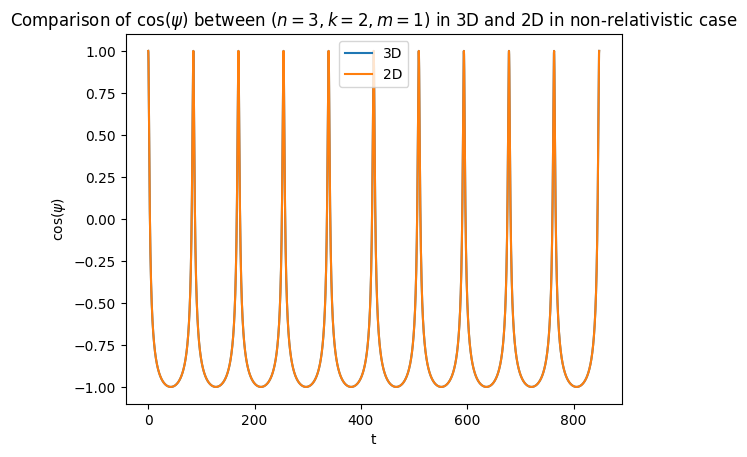

In [57]:
plt.plot(s3d_3_2_1['t'], cos_psi_3d_3_2_1)
plt.plot(s2d_3_2_0['t'], np.cos(s2d_3_2_0['phi']))
plt.xlabel('t')
plt.ylabel('$\\cos(\\psi)$')
plt.legend(['3D', '2D'])
plt.title('Comparison of $\\cos(\\psi)$ between $(n=3, k=2, m=1)$ in 3D and 2D in non-relativistic case')

In [22]:
s3d_3_2_2 = pd.read_csv('d33/3d_3_2_2.csv')

In [23]:
sin_0 = compute_sin_theta_0(2, 2)
cos_0 = compute_cos_theta_0(2, 2)

cos_psi_3d_3_2_2 = compute_cos_psi(s3d_3_2_2['phi'], s3d_3_2_2['theta'], sin_0, cos_0)

Text(0.5, 1.0, 'Comparison of $\\cos(\\psi)$ between $(n=3, k=2, m=2)$ in 3D and 2D in non-relativistic case')

/home/musa/files/atom bohr sim/.venv/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/musa/files/atom bohr sim/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


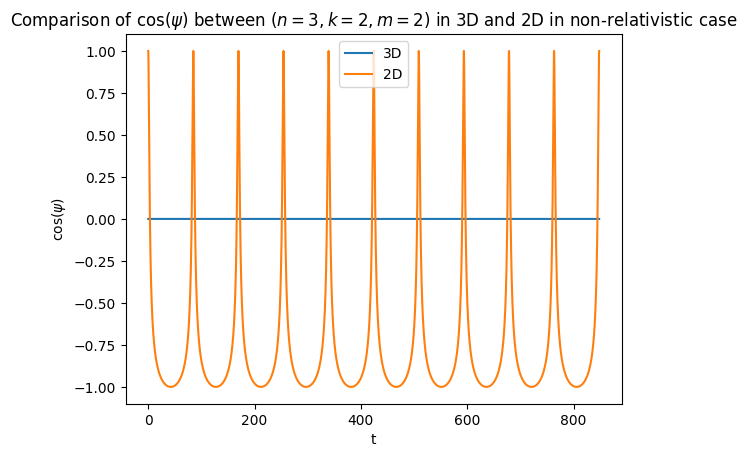

In [60]:
plt.plot(s3d_3_2_2['t'], cos_psi_3d_3_2_2)
plt.plot(s2d_3_2_0['t'], np.cos(s2d_3_2_0['phi']))
plt.xlabel('t')
plt.ylabel('$\\cos(\\psi)$')
plt.legend(['3D', '2D'])
plt.title('Comparison of $\\cos(\\psi)$ between $(n=3, k=2, m=2)$ in 3D and 2D in non-relativistic case')

In [18]:
sphere_3_2_2_d19 = pd.read_csv('results/sphere_3_2_2_d19.csv')

In [31]:
sin_0 = compute_sin_theta_0(2, 2)
cos_0 = compute_cos_theta_0(2, 2)
cos_psi_3_2_2_d19 = compute_cos_psi(sphere_3_2_2_d19['phi'], sphere_3_2_2_d19['theta'], sin_0, cos_0)

In [32]:
sphere_3_2_2_d19

,t,r,r_dot,r_dot_dot,phi,phi_dot,phi_dot_dot,theta,theta_dot,theta_dot_dot
0,0.000001,2.291796,0.000000e+00,0.141910,1.570796,0.0,0.0,3.807834e-07,0.380783,0.0
1,0.000501,2.291796,1.419096e-04,0.141910,1.570796,0.0,0.0,3.811642e-04,0.380783,0.0
2,0.001001,2.291796,2.838192e-04,0.141910,1.570796,0.0,0.0,7.619476e-04,0.380783,0.0
3,0.001501,2.291797,4.257287e-04,0.141909,1.570796,0.0,0.0,1.142731e-03,0.380783,0.0
4,0.002001,2.291797,5.676380e-04,0.141909,1.570796,0.0,0.0,1.523514e-03,0.380783,0.0
...,...,...,...,...,...,...,...,...,...,...
678586,339.293001,2.291793,-5.216543e-04,0.141911,-1.570796,0.0,0.0,1.405372e-03,-0.380785,0.0
678587,339.293501,2.291792,-3.797437e-04,0.141911,-1.570796,0.0,0.0,1.024587e-03,-0.380785,0.0
678588,339.294001,2.291792,-2.378331e-04,0.141911,-1.570796,0.0,0.0,6.438026e-04,-0.380785,0.0
678589,339.294501,2.291792,-9.592230e-05,0.141911,-1.570796,0.0,0.0,2.630177e-04,-0.380785,0.0


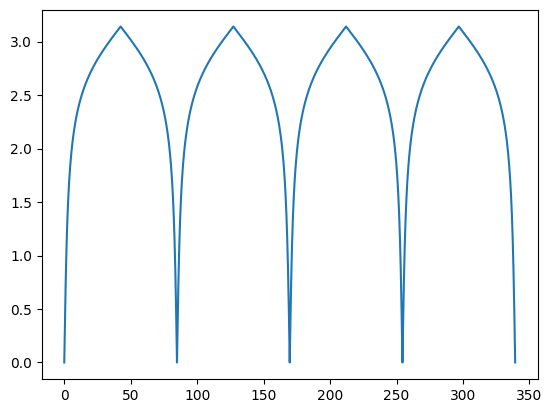

In [33]:
plt.plot(sphere_3_2_2_d19['t'], sphere_3_2_2_d19['theta'])

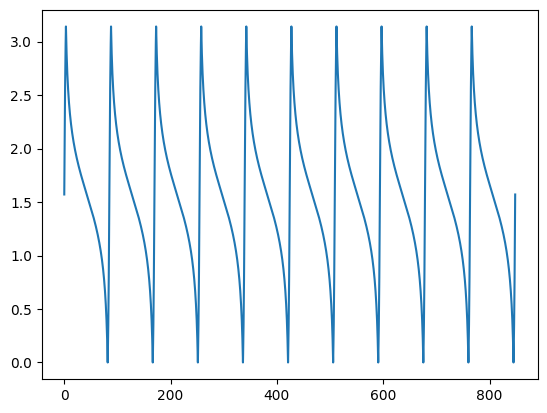

In [34]:
plt.plot(s3d_3_2_2['t'], s3d_3_2_2['theta'])

In [26]:
s3d_3_2_2

,t,r,r_dot,r_dot_dot,phi,phi_dot,phi_dot_dot,theta,theta_dot,theta_dot_dot
0,0.000001,2.291796,0.000000,0.141910,1.570796,0.0,0.0,1.570797,0.380783,0.0
1,0.000501,2.291796,0.000142,0.141910,1.570796,0.0,0.0,1.571177,0.380783,0.0
2,0.001001,2.291796,0.000284,0.141910,1.570796,0.0,0.0,1.571558,0.380783,0.0
3,0.001501,2.291797,0.000426,0.141909,1.570796,0.0,0.0,1.571939,0.380783,0.0
4,0.002001,2.291797,0.000568,0.141909,1.570796,0.0,0.0,1.572320,0.380783,0.0
...,...,...,...,...,...,...,...,...,...,...
1696491,848.245501,2.291787,-0.000628,0.141912,1.570796,0.0,0.0,1.569099,0.380787,0.0
1696492,848.246001,2.291786,-0.000486,0.141912,1.570796,0.0,0.0,1.569480,0.380787,0.0
1696493,848.246501,2.291786,-0.000344,0.141912,1.570796,0.0,0.0,1.569861,0.380787,0.0
1696494,848.247001,2.291785,-0.000202,0.141912,1.570796,0.0,0.0,1.570241,0.380787,0.0


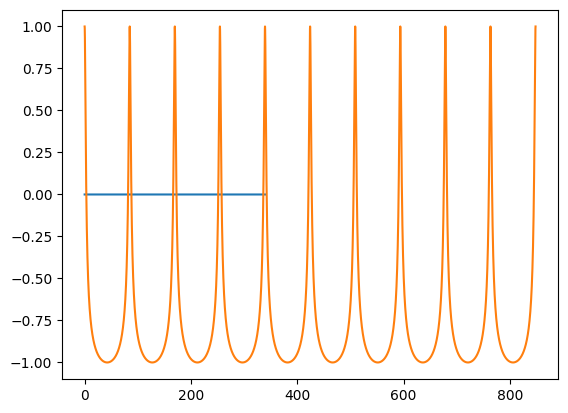

In [38]:
plt.plot(sphere_3_2_2_d19['t'], cos_psi_3_2_2_d19)
plt.plot(s2d_3_2_0['t'], np.cos(s2d_3_2_0['phi']))

In [45]:
s3d_3_2_2_d1 = pd.read_csv('d33/3d_3_2_2_d1.csv')

In [46]:
sin_0 = compute_sin_theta_0(2, 2)
cos_0 = compute_cos_theta_0(2, 2)

cos_psi_3d_3_2_2_d1 = compute_cos_psi(s3d_3_2_2_d1['phi'], s3d_3_2_2_d1['theta'], sin_0, cos_0)

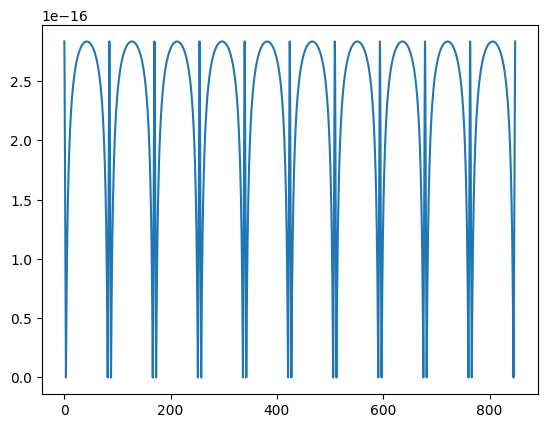

In [47]:
plt.plot(s3d_3_2_2_d1['t'], cos_psi_3d_3_2_2_d1)


In [48]:
s3d_2_1_1_d2 = pd.read_csv('d33/3d_2_1_1_d2.csv')

In [51]:
sin_0 = compute_sin_theta_0(1, 1)
cos_0 = compute_cos_theta_0(1, 1)

cos_psi_3d_2_1_1_d2 = compute_cos_psi(s3d_2_1_1_d2['theta'], s3d_2_1_1_d2['phi'], sin_0, cos_0)

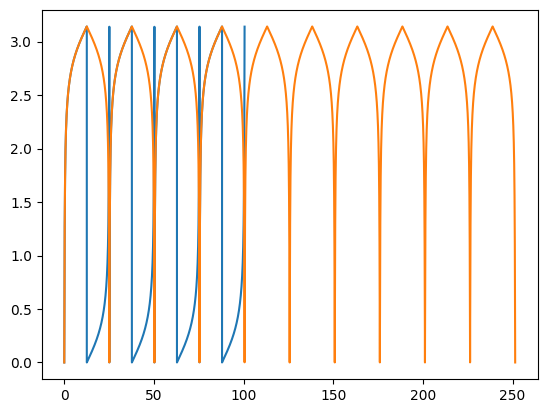

In [53]:
plt.plot(s3d_2_1_1_d2['t'], np.acos(cos_psi_3d_2_1_1_d2))
plt.plot(s2d_2_1_0['t'], np.acos(np.cos(s2d_2_1_0['phi'])))